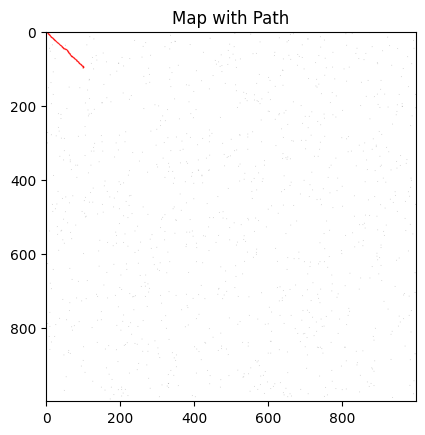

In [27]:
"""
rrt.py

This file implements the RRT (Rapidly-Exploring Random Tree) algorithm in 2D space.
It generates a feasible path for a robot to navigate from a start point to a goal point,
avoiding obstacles in the environment.

Original Author: Huiming Zhou

Modified by: universea
Email: pengsong.zhang@mail.utoronto.ca

"""

import os
import sys
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt


class Node:
    def __init__(self, n):
        self.x = n[0]
        self.y = n[1]
        self.parent = None


class RRT:
    def __init__(self, env, s_start, s_goal, step_len, goal_sample_rate, iter_max):
        self.s_start = Node(s_start)
        self.s_goal = Node(s_goal)
        self.step_len = step_len
        self.goal_sample_rate = goal_sample_rate
        self.iter_max = iter_max
        self.vertex = [self.s_start]

        self.env = env

        self.x_range = (0, self.env.shape[1])
        self.y_range = (0, self.env.shape[0])


    def is_collision(self, node_start, node_end):
        delta = self.step_len
        x_start, y_start = int(node_start.x), int(node_start.y)
        x_end, y_end = int(node_end.x), int(node_end.y)

        dx = abs(x_end - x_start)
        dy = abs(y_end - y_start)

        if dx == 0 and dy == 0:
            return self.env[y_start, x_start] == 1

        if dx > dy:
            x, y = x_start, y_start
            x_step = 1 if x_end > x_start else -1
            y_step = dy / dx if y_end > y_start else -dy / dx

            while x != x_end:
                if self.env[int(round(y)), x] == 1:
                    return True
                x += x_step
                y += y_step
        else:
            x, y = x_start, y_start
            y_step = 1 if y_end > y_start else -1
            x_step = dx / dy if x_end > x_start else -dx / dy

            while y != y_end:
                if self.env[y, int(round(x))] == 1:
                    return True
                x += x_step
                y += y_step

        return False

    def planning(self):
        for i in range(self.iter_max):
            node_rand = self.generate_random_node(self.goal_sample_rate)
            node_near = self.nearest_neighbor(self.vertex, node_rand)
            node_new = self.new_state(node_near, node_rand)

            if node_new and not self.is_collision(node_near, node_new):
                self.vertex.append(node_new)
                dist, _ = self.get_distance_and_angle(node_new, self.s_goal)

                if dist <= self.step_len and not self.is_collision(node_new, self.s_goal):
                    self.new_state(node_new, self.s_goal)
                    return self.extract_path(node_new)

        return None

    def generate_random_node(self, goal_sample_rate):
        delta = 0.5

        if np.random.random() > goal_sample_rate:
            return Node((np.random.uniform(self.x_range[0] + delta, self.x_range[1] - delta),
                         np.random.uniform(self.y_range[0] + delta, self.y_range[1] - delta)))

        return self.s_goal

    @staticmethod
    def nearest_neighbor(node_list, n):
        return node_list[int(np.argmin([math.hypot(nd.x - n.x, nd.y - n.y)
                                        for nd in node_list]))]

    def new_state(self, node_start, node_end):
        dist, theta = self.get_distance_and_angle(node_start, node_end)

        dist = min(self.step_len, dist)
        node_new = Node((node_start.x + dist * math.cos(theta),
                         node_start.y + dist * math.sin(theta)))
        node_new.parent = node_start

        return node_new

    def extract_path(self, node_end):
        path = [(self.s_goal.x, self.s_goal.y)]
        node_now = node_end

        while node_now.parent is not None:
            node_now = node_now.parent
            path.append((node_now.x, node_now.y))

        return path

    @staticmethod
    def get_distance_and_angle(node_start, node_end):
        dx = node_end.x - node_start.x
        dy = node_end.y - node_start.y
        return math.hypot(dx, dy), math.atan2(dy, dx)






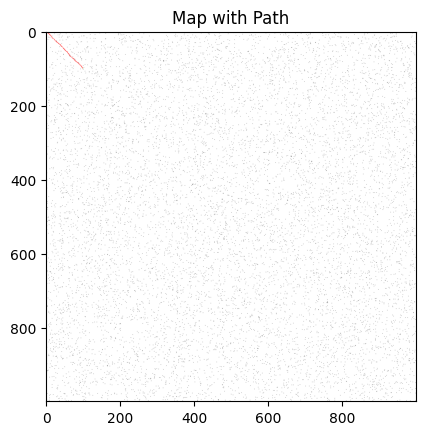

In [32]:
def generate_random_environment(width, height, obstacle_prob):
    random_env = np.random.choice([0, 1], size=(height, width), p=[1 - obstacle_prob, obstacle_prob])
    random_env_image = random_env * 255
    return random_env_image


x_start = (2, 2)  # Starting node
x_goal = (100, 100)  # Goal node

# 生成随机的障碍物地图
env = generate_random_environment(1000,1000,0.01)

cv2.imwrite('env.png',env)

rrt = RRT(env, x_start, x_goal, 0.5, 0.05, 10000)
path = rrt.planning()




# 绘制路径
if path:
    # 获取障碍物地图的形状
    height, width = env.shape

    # 创建一个和障碍物地图相同大小的图像
    map_image = np.zeros((height, width, 3), dtype=np.uint8)

    # 将可行驶区域设置为白色
    map_image[env == 0] = (255, 255, 255)

    # 将障碍物区域设置为黑色
    map_image[env == 1] = (0, 0, 0)

    # 绘制路径
    for i in range(len(path) - 1):
        x1, y1 = int(path[i][0]), int(path[i][1])
        x2, y2 = int(path[i+1][0]), int(path[i+1][1])
        cv2.line(map_image, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)

    # 绘制起点和终点
    map_image[int(rrt.s_start.y), int(rrt.s_start.x)] = (0, 0, 255)  # 起点为蓝色
    map_image[int(rrt.s_goal.y), int(rrt.s_goal.x)] = (0, 255, 0)  # 终点为绿色


    cv2.imwrite('path.png',map_image)

    # 使用imshow函数进行可视化
    plt.imshow(map_image)
    plt.title("Map with Path")
    plt.show()
else:
    print("No Path Found!")

In [30]:
print(path)

[(100, 100), (99.29167314846077, 99.89875926393572), (99.07370307889008, 99.44877143213208), (98.66174213334851, 99.16541974368026), (98.45278738514747, 98.71117541162509), (97.98459137599588, 98.53569750129301), (97.64124366508585, 98.17222487589622), (97.61252236172852, 97.67305047076965), (97.13063233965656, 97.5397012801929), (96.8177546926598, 97.14969156491676), (96.55578426318928, 96.72381424210768), (96.19350421042749, 96.37920843343505), (95.70299873807062, 96.28223224260472), (95.23968121339215, 96.09425120280066), (95.0098994468557, 95.6501787540185), (94.51233837242647, 95.60085353518639), (94.01551378382162, 95.54459228602128), (93.5376957509123, 95.39731727990456), (93.05839427776245, 95.25494418611093), (92.65937913634014, 94.95363551229664), (92.6905126444399, 94.45460574898247), (92.43378643914602, 94.02554671398215), (92.03289476896725, 93.72673930312814), (91.60958467368185, 93.46064051840814), (91.15340029245692, 93.2559558577068), (90.69363891582393, 93.05943747038